In [ ]:
import numpy as np, pandas as pd
import os
import datetime as datetime
import matplotlib.pyplot as plt
import seaborn as sns
import urllib.request
import requests
import sqlite3 as sql
import json
from bs4 import BeautifulSoup
import json
from PIL import Image
from dotenv import load_dotenv

load_dotenv()

: 

In [2]:
tmdb_api_key = os.getenv('TMDB_API_KEY')
data_loc = os.getenv('DATA_PATH')
letterboxd_exports_folder = os.path.join(data_loc, 'LetterboxdExports')
letterboxd_user_name = os.getenv('LETTERBOXD_USER')
latest_date = datetime.datetime.strptime('20200101', '%Y%m%d')
db_name = 'lb-film.db'
film_db_path = os.path.join(data_loc, db_name)

for i in os.listdir(letterboxd_exports_folder):
    if i[0] != '.':
        tmp = i.replace('letterboxd-'+letterboxd_user_name+'-', '')
        tmp_parsed = datetime.datetime.strptime(tmp, '%Y-%m-%d-%H-%M-%Z')
        if tmp_parsed > latest_date:
            latest_date = tmp_parsed
print('latest_export_date = {}'.format(datetime.datetime.strftime(latest_date, '%Y-%m-%d %H:%M')))

latest_export_filename = 'letterboxd-' + letterboxd_user_name + '-' + datetime.datetime.strftime(latest_date, '%Y-%m-%d-%H-%M-%Z')+'utc'
latest_export_file_loc = os.path.join(letterboxd_exports_folder, latest_export_filename)
print('Latest export file location - {}'.format(latest_export_file_loc))

latest_export_date = 2022-09-08 15:58
Latest export file location - /Users/tomdevine/dev/python/Projects/PersonalProjects/Data/LetterboxdExports/letterboxd-td1138-2022-09-08-15-58-utc


## Let's define some functions for interacting with our database:

In [3]:
def db_info(db_path):
    '''
    prints out all of the columns of every table in db
    c : cursor object
    conn : database connection object
    '''
    db_conn = sql.connect(db_path)
    connection_cursor = db_conn.cursor()
    tables = connection_cursor.execute("SELECT name FROM sqlite_master WHERE type='table';").fetchall()
    if len(tables) == 0:
        print('This database has no tables yet!')
    else:
        for table_name in tables:
            table_name = table_name[0] # tables is a list of single item tuples
            table = pd.read_sql_query("SELECT * from {} LIMIT 0".format(table_name), db_conn)
            print(table_name)
            for col in table.columns:
                print('\t' + col)
    db_conn.close()
    return None

In [4]:
def df_to_table(df, db_path, table_name, replace_append='replace'):
    db_conn = sql.connect(db_path)
    try:
        df.columns = [col.upper() for col in df.columns]
        df.to_sql(table_name, db_conn, if_exists=replace_append, index=False)
        db_conn.close()
        print('dataframe succesfully added to the database {} with the table name {}'.format(db_path, table_name))
    except:
        db_conn.close()
        print('Error - dataframe couldn\'t be added to the database')

In [5]:
def drop_table(db_path, table_name):
    db_conn = sql.connect(db_path)
    try:
        drop_statement = 'DROP TABLE {}'.format(table_name)
        db_conn.cursor().execute(drop_statement)
        db_conn.close()
        return print('Table {} dropped successfully'.format(table_name))
    except:
        db_conn.close()
        return print('Error in dropping the table')

In [6]:
def table_to_df(db_path, table_name):
    db_conn = sql.connect(db_path)
    select_statement = 'SELECT * FROM {}'.format(table_name)
    df = pd.read_sql(select_statement, db_conn)
    db_conn.close()
    return df

In [7]:
db_info(film_db_path)

WATCHED
	FILM_ID
	FILM_NAME
	FILM_YEAR
	LETTERBOXD_URI
DIARY
	FILM_ID
	WATCH_DATE
	FILM_RATING
	TAGS
	FIRST_TIME_WATCH
RANKING
	FILM_ID
	FILM_POSITION


In [8]:
def convert_uri_to_id(letterboxd_uri):
    return 'f_'+letterboxd_uri.replace('https://boxd.it/', '').zfill(5)

In [9]:
# This is every film I've ever watched - this will form a perfect basis for scraping the metadata for our movie database.
watched_df = pd.read_csv(os.path.join(latest_export_file_loc, 'watched.csv'))
watched_df['FILM_ID'] = watched_df['Letterboxd URI'].apply(convert_uri_to_id)
watched_df.columns = ['DATE', 'FILM_NAME', 'FILM_YEAR', 'LETTERBOXD_URI', 'FILM_ID']
watched_df = watched_df[['FILM_ID', 'FILM_NAME', 'FILM_YEAR', 'LETTERBOXD_URI']]
watched_df

,FILM_ID,FILM_NAME,FILM_YEAR,LETTERBOXD_URI
0,f_01ZLI,Jumanji,1995,https://boxd.it/1ZLI
1,f_01UTC,Fatal Attraction,1987,https://boxd.it/1UTC
2,f_020E4,Punch-Drunk Love,2002,https://boxd.it/20E4
3,f_01TBi,Altered States,1980,https://boxd.it/1TBi
4,f_03z48,The Fear of God: 25 Years of The Exorcist,1998,https://boxd.it/3z48
...,...,...,...,...
2133,f_0kgNM,Warp Speed Chic,2018,https://boxd.it/kgNM
2134,f_020uI,The Man Who Knew Too Much,1934,https://boxd.it/20uI
2135,f_0pSAG,Cadaver,2020,https://boxd.it/pSAG
2136,f_0qTKY,Licorice Pizza,2021,https://boxd.it/qTKY


In [10]:
df_to_table(watched_df, film_db_path, 'WATCHED')

dataframe succesfully added to the database /Users/tomdevine/dev/python/Projects/PersonalProjects/Data/lb-film.db with the table name WATCHED


In [11]:
diary_df_raw = pd.read_csv(os.path.join(latest_export_file_loc, 'diary.csv'))
diary_df_raw = diary_df_raw[['Watched Date', 'Name', 'Year', 'Rating', 'Rewatch', 'Tags']]
diary_df_raw.columns = ['WATCH_DATE', 'FILM_NAME', 'FILM_YEAR', 'FILM_RATING', 'REWATCH', 'TAGS']
diary_df = diary_df_raw.merge(watched_df, how='left', left_on=['FILM_NAME', 'FILM_YEAR'], right_on=['FILM_NAME', 'FILM_YEAR'])
diary_df['FIRST_TIME_WATCH'] = np.where(diary_df['REWATCH']=='Yes', 0, 1)
diary_df['REWATCH'] = np.where(diary_df['REWATCH']=='Yes', 1, 0)
diary_df['TAGS'] = diary_df['TAGS'].fillna('')
diary_df['TAG_COUNT'] = diary_df['TAGS'].apply(lambda x: 1+x.count(','))
diary_df_output = diary_df[['FILM_ID', 'WATCH_DATE', 'FILM_RATING', 'TAGS', 'FIRST_TIME_WATCH']]
diary_df_output

,FILM_ID,WATCH_DATE,FILM_RATING,TAGS,FIRST_TIME_WATCH
0,f_01ZLI,2021-01-01,2.5,,1
1,f_01UTC,2021-01-01,4.0,,1
2,f_020E4,2021-01-02,3.0,physicalmedia,1
3,f_01TBi,2021-01-02,4.0,physicalmedia,1
4,f_03z48,2021-01-02,4.0,bbciplayer,1
...,...,...,...,...,...
740,f_0kgNM,2022-08-30,3.5,youtube,1
741,f_020uI,2022-08-30,3.0,plex,1
742,f_0pSAG,2022-08-31,3.0,netflix,1
743,f_0qTKY,2022-09-07,3.0,primevideo,1


In [12]:
df_to_table(diary_df_output, film_db_path, 'DIARY')

dataframe succesfully added to the database /Users/tomdevine/dev/python/Projects/PersonalProjects/Data/lb-film.db with the table name DIARY


In [13]:
db_info(film_db_path)

RANKING
	FILM_ID
	FILM_POSITION
WATCHED
	FILM_ID
	FILM_NAME
	FILM_YEAR
	LETTERBOXD_URI
DIARY
	FILM_ID
	WATCH_DATE
	FILM_RATING
	TAGS
	FIRST_TIME_WATCH


In [14]:
ranking_list = pd.read_csv(os.path.join(latest_export_file_loc, 'lists/every-film-ranked-experiment.csv'), skiprows=3)
ranking_list['film_id'] = ranking_list['URL'].apply(convert_uri_to_id)
ranking_list.columns = ['FILM_POSITION', 'FILM_NAME', 'FILM_YEAR', 'LETTERBOXD_URI', 'DESCRIPTION', 'FILM_ID']
ranking_list['FILM_POSITION'] = ranking_list['FILM_POSITION'].astype('Int64')
ranking_list_output = ranking_list[['FILM_ID', 'FILM_POSITION']]
ranking_list_output

,FILM_ID,FILM_POSITION
0,f_027US,1
1,f_027Vw,2
2,f_027Vm,3
3,f_0072s,4
4,f_02aA2,5
...,...,...
542,f_037n2,543
543,f_01TWq,544
544,f_01c3M,545
545,f_03ZZk,546


In [15]:
df_to_table(ranking_list_output, film_db_path, 'RANKING')

dataframe succesfully added to the database /Users/tomdevine/dev/python/Projects/PersonalProjects/Data/lb-film.db with the table name RANKING


In [16]:
diary_df = diary_df.merge(ranking_list_output[['FILM_ID', 'FILM_POSITION']], how='left', on='FILM_ID')
diary_df['NARRATIVE_FEATURE'] = np.where(diary_df['FILM_POSITION'].isnull(), 0, 1)
feature_diary_df = diary_df[diary_df['NARRATIVE_FEATURE']==1].reset_index(drop=True)

In [17]:
feature_diary_df

,WATCH_DATE,FILM_NAME,FILM_YEAR,FILM_RATING,REWATCH,TAGS,FILM_ID,LETTERBOXD_URI,FIRST_TIME_WATCH,TAG_COUNT,FILM_POSITION,NARRATIVE_FEATURE
0,2021-01-01,Jumanji,1995,2.5,0,,f_01ZLI,https://boxd.it/1ZLI,1,1,443,1
1,2021-01-01,Fatal Attraction,1987,4.0,0,,f_01UTC,https://boxd.it/1UTC,1,1,183,1
2,2021-01-02,Punch-Drunk Love,2002,3.0,0,physicalmedia,f_020E4,https://boxd.it/20E4,1,1,316,1
3,2021-01-02,Altered States,1980,4.0,0,physicalmedia,f_01TBi,https://boxd.it/1TBi,1,1,116,1
4,2021-01-03,The Skin I Live In,2011,3.0,0,physicalmedia,f_0099A,https://boxd.it/99A,1,1,376,1
...,...,...,...,...,...,...,...,...,...,...,...,...
549,2022-08-25,Little Shop of Horrors,1986,5.0,1,physicalmedia,f_01Vqm,https://boxd.it/1Vqm,0,1,33,1
550,2022-08-30,The Man Who Knew Too Much,1934,3.0,0,plex,f_020uI,https://boxd.it/20uI,1,1,389,1
551,2022-08-31,Cadaver,2020,3.0,0,netflix,f_0pSAG,https://boxd.it/pSAG,1,1,391,1
552,2022-09-07,Licorice Pizza,2021,3.0,0,primevideo,f_0qTKY,https://boxd.it/qTKY,1,1,397,1


In [18]:
tmp = feature_diary_df.groupby('FILM_RATING').agg({'FILM_POSITION':['min', 'max', 'count']}).reset_index()
tmp.columns = ['RATING_QUANT', 'MIN_POSITION', 'MAX_POSITION', 'FILM_COUNT']
tmp

,RATING_QUANT,MIN_POSITION,MAX_POSITION,FILM_COUNT
0,0.5,546,547,2
1,1.0,529,545,17
2,1.5,499,528,30
3,2.0,476,498,23
4,2.5,420,475,56
5,3.0,302,419,119
6,3.5,212,301,91
7,4.0,96,211,119
8,4.5,34,95,63
9,5.0,1,33,34


In [19]:
ratings_dict = {}
for rating in sorted(feature_diary_df['FILM_RATING'].unique(), reverse=True):
    tmp_df = feature_diary_df[feature_diary_df['FILM_RATING']==rating]
    rating_count = len(tmp_df['FILM_NAME'].unique())
    increment = 0.5/rating_count
    highest_position = tmp_df['FILM_POSITION'].min()
    ratings_dict[rating] = {'RATING_COUNT':rating_count, 'INCREMENT':increment, 'MAX_POSITION':highest_position}
ratings_dict

{5.0: {'RATING_COUNT': 33,
  'INCREMENT': 0.015151515151515152,
  'MAX_POSITION': 1},
 4.5: {'RATING_COUNT': 60,
  'INCREMENT': 0.008333333333333333,
  'MAX_POSITION': 34},
 4.0: {'RATING_COUNT': 116,
  'INCREMENT': 0.004310344827586207,
  'MAX_POSITION': 96},
 3.5: {'RATING_COUNT': 90,
  'INCREMENT': 0.005555555555555556,
  'MAX_POSITION': 212},
 3.0: {'RATING_COUNT': 118,
  'INCREMENT': 0.00423728813559322,
  'MAX_POSITION': 302},
 2.5: {'RATING_COUNT': 56,
  'INCREMENT': 0.008928571428571428,
  'MAX_POSITION': 420},
 2.0: {'RATING_COUNT': 23,
  'INCREMENT': 0.021739130434782608,
  'MAX_POSITION': 476},
 1.5: {'RATING_COUNT': 30,
  'INCREMENT': 0.016666666666666666,
  'MAX_POSITION': 499},
 1.0: {'RATING_COUNT': 17,
  'INCREMENT': 0.029411764705882353,
  'MAX_POSITION': 529},
 0.5: {'RATING_COUNT': 2, 'INCREMENT': 0.25, 'MAX_POSITION': 546}}

In [20]:
def scale_rating(basic_rating, position):
    dict_entry = ratings_dict[basic_rating]
    relative_position = position - dict_entry['MAX_POSITION']
    required_increment = relative_position*dict_entry['INCREMENT']
    final_rating = basic_rating - required_increment
    return final_rating

In [21]:
feature_diary_df['RATING_ADJUSTED'] = feature_diary_df.apply(lambda row: scale_rating(row['FILM_RATING'], row['FILM_POSITION']), axis=1)
feature_diary_df.head()

,WATCH_DATE,FILM_NAME,FILM_YEAR,FILM_RATING,REWATCH,TAGS,FILM_ID,LETTERBOXD_URI,FIRST_TIME_WATCH,TAG_COUNT,FILM_POSITION,NARRATIVE_FEATURE,RATING_ADJUSTED
0,2021-01-01,Jumanji,1995,2.5,0,,f_01ZLI,https://boxd.it/1ZLI,1,1,443,1,2.294643
1,2021-01-01,Fatal Attraction,1987,4.0,0,,f_01UTC,https://boxd.it/1UTC,1,1,183,1,3.625000
2,2021-01-02,Punch-Drunk Love,2002,3.0,0,physicalmedia,f_020E4,https://boxd.it/20E4,1,1,316,1,2.940678
3,2021-01-02,Altered States,1980,4.0,0,physicalmedia,f_01TBi,https://boxd.it/1TBi,1,1,116,1,3.913793
4,2021-01-03,The Skin I Live In,2011,3.0,0,physicalmedia,f_0099A,https://boxd.it/99A,1,1,376,1,2.686441


In [23]:
def barplot_mean(df, group_col, mean_col, minimum_grouping_count=None):
    df[group_col] = df[group_col].astype(str)
    tmp = df.groupby(group_col).agg({mean_col:['mean', 'count']}).reset_index()
    tmp = tmp[tmp[group_col] != '']
    tmp.columns = ['_'.join(col) if col[0] != group_col else col[0] for col in tmp.columns]
    if minimum_grouping_count is not None:
        tmp = tmp[tmp[mean_col+'_count']>=minimum_grouping_count]
    tmp = tmp.sort_values(mean_col+'_mean', ascending=False)
    tmp[mean_col+'_count'] = tmp[mean_col+'_count'].astype('float64')
    tmp_plot = sns.barplot(data=tmp, y=group_col, x=mean_col+'_mean', hue=mean_col+'_count', dodge=False, palette='Blues')
    plt.title('mean ' + mean_col + ' grouped by ' + group_col)
    return plt.show()

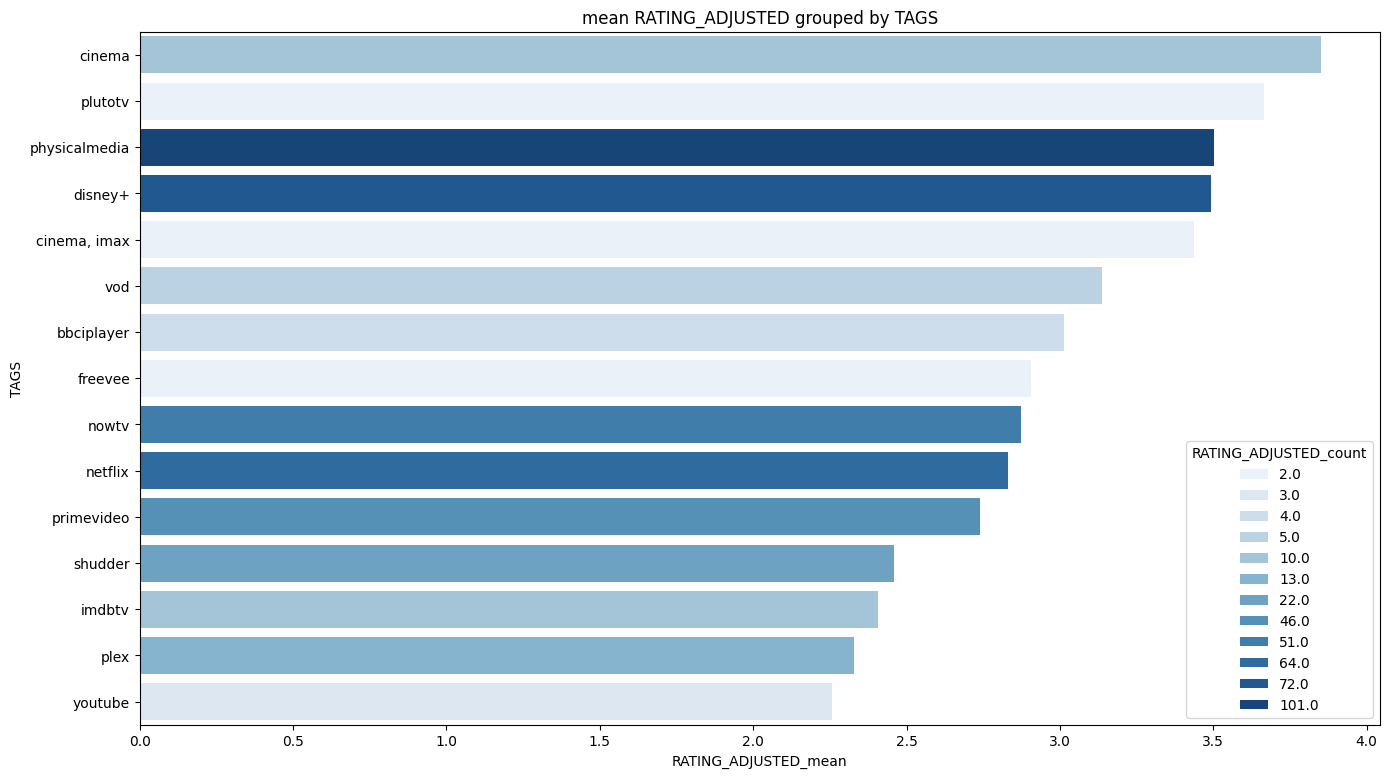

In [24]:
fig = plt.figure(figsize=(16,9))

barplot_mean(feature_diary_df, 'TAGS', 'RATING_ADJUSTED', 2)

,rating,film_count,rating_str
0,5.0,33.0,5.0 stars
1,4.5,60.0,4.5 stars
2,4.0,116.0,4.0 stars
3,3.5,90.0,3.5 stars
4,3.0,118.0,3.0 stars
5,2.5,56.0,2.5 stars
6,2.0,23.0,2.0 stars
7,1.5,30.0,1.5 stars
8,1.0,17.0,1.0 stars
9,0.5,2.0,0.5 stars


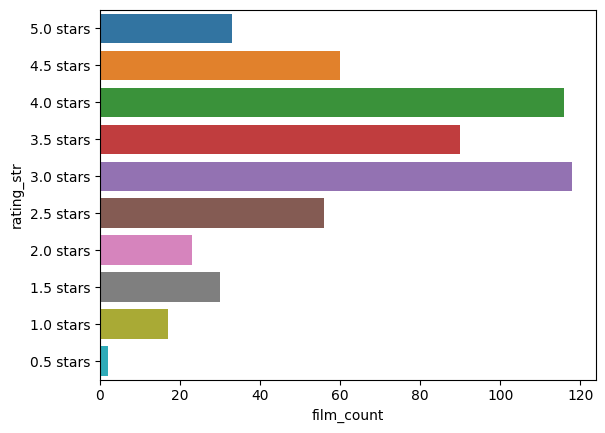

In [25]:
ratings_df = pd.DataFrame(ratings_dict).T.reset_index()[['index', 'RATING_COUNT']]
ratings_df.columns = ['rating', 'film_count']
ratings_df['rating_str'] = ratings_df['rating'].astype(str) + ' stars'
sns.barplot(data=ratings_df, y='rating_str', x='film_count', orient='h')
ratings_df

In [39]:
ordered__film_list = feature_diary_df[['FILM_NAME', 'FILM_POSITION', 'FILM_RATING', 'RATING_ADJUSTED']].groupby(['FILM_NAME', 'FILM_POSITION', 'FILM_RATING']).mean().sort_values('RATING_ADJUSTED', ascending=False).reset_index()
ordered__film_list.iloc[200:220, :]

,FILM_NAME,FILM_POSITION,FILM_RATING,RATING_ADJUSTED
200,Nope,201,4.0,3.547414
201,Titan A.E.,202,4.0,3.543103
202,The Living Dead Girl,203,4.0,3.538793
203,Ocean's Twelve,204,4.0,3.534483
204,Chopping Mall,205,4.0,3.530172
205,The Frighteners,206,4.0,3.525862
206,The French Dispatch,207,4.0,3.521552
207,Office Space,208,4.0,3.517241
208,Deep Rising,209,4.0,3.512931
209,Night of the Demons,210,4.0,3.508621


In [36]:
ratings_df

,rating,film_count,rating_str
0,5.0,33.0,5.0 stars
1,4.5,60.0,4.5 stars
2,4.0,116.0,4.0 stars
3,3.5,90.0,3.5 stars
4,3.0,118.0,3.0 stars
5,2.5,56.0,2.5 stars
6,2.0,23.0,2.0 stars
7,1.5,30.0,1.5 stars
8,1.0,17.0,1.0 stars
9,0.5,2.0,0.5 stars


In [ ]:
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.common.by import By
import chromedriver_autoinstaller

chromedriver_autoinstaller.install()

chrome_options = Options()
chrome_options.add_argument("--headless")
# chrome_options.add_argument("download.default_directory: {}".format(letterboxd_exports_folder))

HOME_PAGE = 'https://letterboxd.com/'
ACCOUNT = 'tomdevine1138@gmail.com'
PASSWORD = 'b0baletterboxd'
SETTINGS_PAGE = 'https://letterboxd.com/settings/data/'

: 

In [ ]:
driver = webdriver.Chrome(options=chrome_options)
driver.get(SETTINGS_PAGE)
driver.implicitly_wait(5)
accept_cookies = driver.find_element(By.XPATH, '//*[@id="tyche_cmp_modal"]/div/div/div/div[5]/div[2]/a')
accept_cookies.click()
username = driver.find_element(By.XPATH, '//*[@id="signin-username"]')
username.send_keys(ACCOUNT)
password = driver.find_element(By.XPATH, '//*[@id="signin-password"]')
password.send_keys(PASSWORD)
signin_button = driver.find_element(By.XPATH, '//*[@id="signin-form"]/fieldset/div[4]/div/input')
signin_button.click()
export_button = driver.find_element(By.XPATH, '//*[@id="data"]/p[3]/a')
export_button.click()
export_button2 = driver.find_element(By.XPATH, '//*[@id="modal"]/article/div/div[2]/a')
export_button2.click()



: 

In [108]:
x

'letterboxd-td1138-2022-09-19-13-13-utc.zip'

In [ ]:
os.mkdir

In [105]:
for x in os.listdir():
    if x[-4:] == '.zip':
        os.rename("path/to/current/file.foo", "path/to/new/destination/for/file.foo")
    

letterboxd-td1138-2022-09-19-13-13-utc.zip


In [ ]:
os.rename("path/to/current/file.foo", "path/to/new/destination/for/file.foo")

In [56]:
from tmdbv3api import TMDb
tmdb = TMDb()
tmdb.api_key = tmdb_api_key

In [57]:
from tmdbv3api import Movie
movie = Movie()

m = movie.details(603)

print(m.title)
print(m.overview)
print(m.popularity)

The Matrix
Set in the 22nd century, The Matrix tells the story of a computer hacker who joins a group of underground insurgents fighting the vast and powerful computers who now rule the earth.
59.259


In [58]:
required_keys = ['adult',
                 'title',
                 'budget',
                 'genres',
                 'original_language',
                 'original_title',
                 'poster_path',
                 'production_countries',
                 'release_date',
                 'revenue',
                 'runtime',
                 'casts']

In [59]:
'https://image.tmdb.org/t/p/original' + '/bV9qTVHTVf0gkW0j7p7M0ILD4pG.jpg'

'https://image.tmdb.org/t/p/original/bV9qTVHTVf0gkW0j7p7M0ILD4pG.jpg'

In [77]:
for k in m.keys():
    if k in required_keys:
        print('\n{} = {}'.format(k, m[k]))

    


adult = False

budget = 63000000

genres = [{'id': 28, 'name': 'Action'}, {'id': 878, 'name': 'Science Fiction'}]

original_language = en

original_title = The Matrix

poster_path = /f89U3ADr1oiB1s9GkdPOEpXUk5H.jpg

production_countries = [{'iso_3166_1': 'US', 'name': 'United States of America'}]

release_date = 1999-03-30

revenue = 463517383

runtime = 136

title = The Matrix

casts = {'cast': [{'adult': False, 'gender': 2, 'id': 6384, 'known_for_department': 'Acting', 'name': 'Keanu Reeves', 'original_name': 'Keanu Reeves', 'popularity': 22.152, 'profile_path': '/4D0PpNI0kmP58hgrwGC3wCjxhnm.jpg', 'cast_id': 34, 'character': 'Thomas A. Anderson / Neo', 'credit_id': '52fe425bc3a36847f80181c1', 'order': 0}, {'adult': False, 'gender': 2, 'id': 2975, 'known_for_department': 'Acting', 'name': 'Laurence Fishburne', 'original_name': 'Laurence Fishburne', 'popularity': 18.507, 'profile_path': '/8suOhUmPbfKqDQ17jQ1Gy0mI3P4.jpg', 'cast_id': 21, 'character': 'Morpheus', 'credit_id': '52fe425bc

In [61]:
m.runtime

136

In [62]:
def tmdb_info(tmdb_movie_id):
    movie = Movie()
    response = movie.details(tmdb_movie_id)
    print(response.)

SyntaxError: invalid syntax (752420168.py, line 4)

In [63]:
def letterboxd(url, verbose=False):
    headers = {
        'user-agent': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/80.0.3987.163 Safari/537.36',
        'referer': 'https://google.com',
    }
    if verbose: print('URL requested was {}'.format(url))
    r = requests.get(url, headers=headers)
    redirected_url = r.url
    if verbose and (url != redirected_url):
        print('Final redirected URL was {}'.format(redirected_url))
    r = requests.get(redirected_url, headers=headers)
    content_string = str(r.content)
    soup = BeautifulSoup(r.content, 'lxml')

    item = {}
    
    title = soup.find('meta', {'property': 'og:title'}).get('content')
    cast = [cast.text for cast in soup.find_all('a', {'class': 'text-slug tooltip'})]
    characters = [str(cast)[str(cast).find('title=')+7:str(cast).find(">")-1] for cast in soup.find_all('a', {'class': 'text-slug tooltip'})]
    directors = [directors.text for directors in soup.find_all('span', {'class': 'prettify'})]
    rating = soup.find('meta', {'name': 'twitter:data2'}).get('content')
    directors = soup.find_all('div', {'class': 'text-sluglist'})[1]
    directors = [directors.text for directors in directors.find_all('a')]
    producers = soup.find_all('div', {'class': 'text-sluglist'})[2]
    producers = [producers.text for producers in producers.find_all('a')]
    writers = soup.find_all('div', {'class': 'text-sluglist'})[3]
    writers = [writers.text for writers in writers.find_all('a')]
    editors = soup.find_all('div', {'class': 'text-sluglist'})[4]
    editors = [editors.text for editors in editors.find_all('a')]
    cinematographers = soup.find_all('div', {'class': 'text-sluglist'})[5]
    cinematographers = [cinematographers.text for cinematographers in cinematographers.find_all('a')]
    composers = soup.find_all('div', {'class': 'text-sluglist'})[10]
    composers = [composers.text for composers in composers.find_all('a')]
    studios = soup.find_all('div', {'class': 'text-sluglist'})[14]
    studios = [studios.text for studios in studios.find_all('a')]
    countries = soup.find_all('div', {'class': 'text-sluglist'})[15]
    countries = [countries.text for countries in countries.find_all('a')]
    languages = soup.find_all('div', {'class': 'text-sluglist'})[16]
    languages = [languages.text for languages in languages.find_all('a')]
    genres = soup.find_all('div', {'class': 'text-sluglist'})[17]
    genres = [genres.text for genres in genres.find_all('a')]
    themes = soup.find_all('div', {'class': 'text-sluglist'})[18]
    themes = [themes.text for themes in themes.find_all('a')]
    
    
    year = soup.find('small', {'class': 'number'}).text
    
    film_length_start = content_string[content_string.find('<p class="text-link text-footer">')+57:]
    film_length = film_length_start[:film_length_start.find('&nbsp')]
    lazy_load_pos = content_string.find('really-lazy-load poster')
    img_src_0 = lazy_load_pos + content_string[lazy_load_pos:].find('<img src="') + 10
    img_src_1 = img_src_0 + content_string[img_src_0:].find('"')
    img_url = content_string[img_src_0:img_src_1]
    
    
    id_loc_0 = content_string.find('id: ') + 4
    id_loc_1 = content_string.find(',', id_loc_0)
    film_id = 'id_'+content_string[id_loc_0:id_loc_1].zfill(9)
    
    item['unique_id'] = film_id
    item['title'] = title
    item['release_year'] = year
    item['film_length'] = film_length
    item['director'] = directors
    item['cast'] = cast
    item['characters'] = characters
    item['rating'] = rating
    item['genres'] = genres
    item['producers'] = producers
    item['writers'] = writers
    item['editors'] = editors
    item['cinematographers'] = cinematographers
    item['composers'] = composers
    item['studios'] = studios
    item['countries'] = countries
    item['languages'] = languages
    item['themes'] = themes
    
    item['imgurl'] = img_url
    
    og_url = soup.find('meta', {'property': 'og:url'}).get('content')
    film = og_url.split('/')[-2]

    r2 = requests.get('https://letterboxd.com/esi/film/{}/stats/'.format(film), headers=headers)

    soup2 = BeautifulSoup(r2.content, 'lxml')


    watched_by = str(soup2)[str(soup2).find('Watched by ')+11:str(soup2).find('Watched by ')+25]
    watched_by = int(watched_by[0:watched_by.find('\xa0m')].replace(',',''))
    
    listed_by = str(soup2)[str(soup2).find('Appears in ')+11:str(soup2).find('Appears in ')+25]
    listed_by = int(listed_by[0:listed_by.find('\xa0l')].replace(',',''))
    liked_by = str(soup2)[str(soup2).find('Appears in ')+11:str(soup2).find('Appears in ')+25]
    liked_by = int(liked_by[0:liked_by.find('\xa0l')].replace(',',''))

    try:
        top_ = int(soup2.find('a', {'class': 'has-icon icon-top250 icon-16 tooltip'}).text)
    except:
        top_ = None

    item['watch_count'] = watched_by
    item['list_count'] = listed_by
    item['like_count'] = liked_by
    item['top250'] = top_
    item['datacollection_timestamp'] = datetime.datetime.now()
    
    return item

test_film = letterboxd('https://letterboxd.com/film/the-matrix/')
test_film

{'unique_id': 'id_000051518',
 'title': 'The Matrix (1999)',
 'release_year': '1999',
 'film_length': '136',
 'director': ['Lilly Wachowski', 'Lana Wachowski'],
 'cast': ['Keanu Reeves',
  'Laurence Fishburne',
  'Carrie-Anne Moss',
  'Hugo Weaving',
  'Joe Pantoliano',
  'Marcus Chong',
  'Anthony Ray Parker',
  'Matt Doran',
  'Gloria Foster',
  'Belinda McClory',
  'Paul Goddard',
  'Robert Taylor',
  'Ada Nicodemou',
  'Julian Arahanga',
  'David Aston',
  'Marc Aden Gray',
  'Deni Gordon',
  'Rowan Witt',
  'Eleanor Witt',
  'Janaya Pender',
  'Adryn White',
  'Natalie Tjen',
  'Bill Young',
  "David O'Connor",
  'Jeremy Ball',
  'Fiona Johnson',
  'Harry Lawrence',
  'Steve Dodd',
  'Luke Quinton',
  'Lawrence Woodward',
  'Michael Butcher',
  'Bernard Ledger',
  'Chris Pattinson',
  'Robert Simper',
  'Nigel Harbach',
  'Rana Morrison',
  'Tamara Brown'],
 'characters': ['Thomas A. Anderson / Neo',
  'Morpheus',
  'Trinity',
  'Agent Smith',
  'Cypher',
  'Tank',
  'Dozer',
  'M

In [64]:
url = 'https://letterboxd.com/film/the-matrix/'
headers = {
        'user-agent': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/80.0.3987.163 Safari/537.36',
        'referer': 'https://google.com',
    }
r = requests.get(url, headers=headers)
redirected_url = r.url
if (url != redirected_url):
    print('Final redirected URL was {}'.format(redirected_url))
r = requests.get(redirected_url, headers=headers)
content_string = str(r.content)

In [65]:
#cinematographers = 
BeautifulSoup(r.content, 'lxml').find_all('p', {'class': 'text-link text-footer'})[0].find_all('a')




[<a class="micro-button track-event" data-track-action="IMDb" href="http://www.imdb.com/title/tt0133093/maindetails">IMDb</a>,
 <a class="micro-button track-event" data-track-action="TMDb" href="https://www.themoviedb.org/movie/603/">TMDb</a>]

In [66]:
print(content_string[:666])

b'\n\n<!DOCTYPE html>\n\n<!--[if lt IE 7 ]> <html lang="en" class="ie6 lte9 lte8 lte7 lte6 no-js"> <![endif]-->\n<!--[if IE 7 ]>    <html lang="en" class="ie7 lte9 lte8 lte7 no-js"> <![endif]-->\n<!--[if IE 8 ]>    <html lang="en" class="ie8 lte9 lte8 no-js"> <![endif]-->\n<!--[if IE 9 ]>    <html lang="en" class="ie9 lte9 no-js"> <![endif]-->\n<!--[if (gt IE 9)|!(IE)]><!--> <html id="html" lang="en" class="no-mobile no-js"> <!--<![endif]-->\n<head>\n\t<meta charset="UTF-8" />\n\t<meta name="viewport" content="width=1024" />\n\t<meta http-equiv="X-UA-Compatible" content="IE=edge,chrome=1" />\n\t<meta name="description" content="Set in the 22nd century, The M


In [67]:
len('<div class="text-sluglist capitalize"')

37

In [69]:
text_upto = content_string[content_string.find('<div class="text-sluglist capitalize"'):]
text = text_upto[:text_upto.find('&nbsp')]
text_upto

'<div class="text-sluglist capitalize">\\n\\t\\t\\t\\t\\t\\t\\t\\t\\t\\t<p>\\n\\t\\t\\t\\t\\t\\t\\t\\t\\t\\t\\t<a href="/films/genre/science-fiction/" class="text-slug">science-fiction</a> <a href="/films/genre/action/" class="text-slug">action</a> \\n\\t\\t\\t\\t\\t\\t\\t\\t\\t\\t</p>\\n\\t\\t\\t\\t\\t\\t\\t\\t\\t</div>\\n\\t\\t\\t\\t\\t\\t\\t\\t\\n\\t\\t\\t\\t\\t\\t\\t\\t\\n\\t\\t\\t\\t\\t\\t\\t\\t\\t<h3><span>Themes</span></h3>\\n\\t\\t\\t\\t\\t\\t\\t\\t\\t<div class="text-sluglist capitalize">\\n\\t\\t\\t\\t\\t\\t\\t\\t\\t\\t<p>\\n\\t\\t\\t\\t\\t\\t\\t\\t\\t\\t\\t<a href="/films/theme/monsters-aliens-sci-fi-and-the-apocalypse/by/best-match/" class="text-slug">Monsters, aliens, sci-fi and the apocalypse</a> <a href="/films/theme/epic-heroes/by/best-match/" class="text-slug">Epic heroes</a> \\n\\t\\t\\t\\t\\t\\t\\t\\t\\t\\t\\t<a href="/films/mini-theme/future-action-technology-technological-humanity/by/best-match/" class="text-slug">future, sci-fi, technology, action or technological

In [70]:
def grab_img_from_url(url, resize=True, output_size=(256, 256), display_img=False):
    image = Image.open(requests.get(url, stream=True).raw)
    if resize:
        image.thumbnail(output_size)
    if display_img:
        display(image)
    return image

In [71]:
def save_img(pil_img, save_loc):
    try:
        pil_img.save(save_loc)
        return print('Save Successful')
    except:
        return print('Save Unsuccessful')

In [72]:
file_loc = os.path.join(data_loc, 'Posters', 'matrix'+'.jpeg')

In [74]:
tmp_img = grab_img_from_url(test_film['imgurl'], resize=True)

In [76]:
test_film['imgurl']

'https://s.ltrbxd.com/static/img/empty-poster-230.876e6b8e.png'

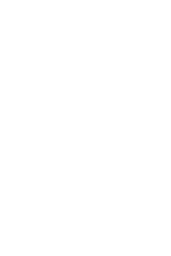

In [75]:
tmp_img